In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten ,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
from keras.callbacks import EarlyStopping

In [ ]:
tf.get_logger().setLevel('ERROR')

In [ ]:
total_samples = 1584 + 1132 + 869 + 585
class1_samples = 1584
class2_samples = 1132
class3_samples = 869
class4_samples = 585

# Calculate weights
weight1 = total_samples / class1_samples
weight2 = total_samples / class2_samples
weight3 = total_samples / class3_samples
weight4 = total_samples / class4_samples

# Normalize weights
total_weight = weight1 + weight2 + weight3 + weight4
weight1 /= total_weight
weight2 /= total_weight
weight3 /= total_weight
weight4 /= total_weight

# Set class weights
class_weights = {0: weight1, 1: weight2, 2: weight3, 3: weight4}

# Define image dimensions
image_height, image_width = 224, 224
num_classes = 4
batch_size = 32
epochs = 50

# Define paths to your training and validation data
train_data_dir = '/content/drive/MyDrive/Ulcerative Colitis/train_and_validation_sets/train_and_validation_sets'
val_data_dir = '/content/drive/MyDrive/Ulcerative Colitis/test_set/test_set'

In [ ]:
def lenet():
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=20,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True)

    val_datagen = ImageDataGenerator(rescale=1./255)


    train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                        target_size=(image_height, image_width),
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        shuffle=True)  # Shuffle the data

    val_generator = val_datagen.flow_from_directory(val_data_dir,
                                                    target_size=(image_height, image_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)  # Don't shuffle validation data
    model = Sequential([
        Conv2D(6, (5, 5), activation='relu', input_shape=(image_height, image_width, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(16, (5, 5), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(120, activation='relu'),
        Dense(84, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Define a learning rate scheduler
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

    early_stopping = EarlyStopping(monitor='accuracy', patience=3, mode='max', verbose=1)


    # Define a checkpoint to save the best model during training
    checkpoint = ModelCheckpoint('best_model_lenet.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

    # Train the model
    history = model.fit(train_generator,
                        steps_per_epoch=len(train_generator),
                        epochs=epochs,
                        validation_data=val_generator,
                        validation_steps=len(val_generator),
                        callbacks=[checkpoint, lr_scheduler, early_stopping],
                        class_weight=class_weights)

    # Plot training history
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.show()

In [ ]:
def resnet50():
    # Use ImageDataGenerator for preprocessing and augmentation
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    # Generate batches of augmented data
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    val_generator = val_datagen.flow_from_directory(
        val_data_dir,
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Load ResNet50 model without the top layer
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

    # Add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Add dropout to reduce overfitting
    x = Dropout(0.5)(x)

    # Add a fully-connected layer
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)

    # Add dropout to reduce overfitting
    x = Dropout(0.5)(x)

    # Add a classification layer for num_classes
    predictions = Dense(num_classes, activation='softmax')(x)

    # Model to be trained
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the layers of the original ResNet50 model up to a certain layer
    for layer in base_model.layers[:140]:
        layer.trainable = False
    for layer in base_model.layers[140:]:
        layer.trainable = True

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Define callbacks
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

    early_stopping = EarlyStopping(monitor='accuracy', patience=3, mode='max', verbose=1)

    checkpoint = ModelCheckpoint('best_model_resnet.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=val_generator,
        validation_steps=len(val_generator),
        callbacks=[checkpoint, lr_scheduler,early_stopping],
        class_weight=class_weights,
        epochs=epochs
    )

    # Plot training history
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='ResNet50 Training Loss')
    plt.plot(history.history['val_loss'], label='ResNet50 Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [ ]:
def alexnet():
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=20,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True)

    val_datagen = ImageDataGenerator(rescale=1./255)

    # Generate batches of augmented data
    train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                        target_size=(image_height, image_width),
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        shuffle=True)  # Shuffle the data

    val_generator = val_datagen.flow_from_directory(val_data_dir,
                                                    target_size=(image_height, image_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)  # Don't shuffle validation data

    # Define AlexNet model
    model = Sequential([
        Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(image_height, image_width, 3)),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        Conv2D(256, (5, 5), activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        Conv2D(384, (3, 3), activation='relu'),
        Conv2D(384, (3, 3), activation='relu'),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Define a learning rate scheduler
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

    early_stopping = EarlyStopping(monitor='accuracy', patience=3, mode='max', verbose=1)

    # Define a checkpoint to save the best model during training
    checkpoint = ModelCheckpoint('best_model_alexnet.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

    # Train the model
    history = model.fit(train_generator,
                        steps_per_epoch=len(train_generator),
                        epochs=epochs,
                        validation_data=val_generator,
                        validation_steps=len(val_generator),
                        callbacks=[checkpoint, lr_scheduler,early_stopping],
                        class_weight=class_weights)

    # Plot training history
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.show()

In [ ]:
def inception_v3():
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    # Generate batches of augmented data
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    val_generator = val_datagen.flow_from_directory(
        val_data_dir,
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))


    # Adding custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

    early_stopping = EarlyStopping(monitor='accuracy', patience=3, mode='max', verbose=1)

    checkpoint = ModelCheckpoint('inception_v3.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=val_generator,
        validation_steps=len(val_generator),
        callbacks=[checkpoint, lr_scheduler,early_stopping],
        class_weight=class_weights,
        epochs=epochs
    )

    # Plot training history
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='InceptionV3 Training Loss')
    plt.plot(history.history['val_loss'], label='InceptionV3 Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [ ]:
def xception():
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    # Generate batches of augmented data
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    val_generator = val_datagen.flow_from_directory(
        val_data_dir,
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

    # Adding custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

    early_stopping = EarlyStopping(monitor='accuracy', patience=3, mode='max', verbose=1)

    checkpoint = ModelCheckpoint('xception.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=val_generator,
        validation_steps=len(val_generator),
        callbacks=[checkpoint, lr_scheduler,early_stopping],
        class_weight=class_weights,
        epochs=epochs
    )

    # Plot training history
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Xception Training Loss')
    plt.plot(history.history['val_loss'], label='Xception Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [ ]:
def mobilenet():

    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    # Generate batches of augmented data
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    val_generator = val_datagen.flow_from_directory(
        val_data_dir,
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

    early_stopping = EarlyStopping(monitor='accuracy', patience=3, mode='max', verbose=1)

    checkpoint = ModelCheckpoint('mobilenet.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

    # Adding custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=val_generator,
        validation_steps=len(val_generator),
        callbacks=[checkpoint, lr_scheduler,early_stopping],
        class_weight=class_weights,
        epochs=epochs
    )

    # Plot training history
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='MobileNet Training Loss')
    plt.plot(history.history['val_loss'], label='MobileNet Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [ ]:
def mobilenet_v2():

    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    # Generate batches of augmented data
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    val_generator = val_datagen.flow_from_directory(
        val_data_dir,
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

    early_stopping = EarlyStopping(monitor='accuracy', patience=3, mode='max', verbose=1)

    checkpoint = ModelCheckpoint('mobilenet_v2.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

    # Adding custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=val_generator,
        validation_steps=len(val_generator),
        callbacks=[checkpoint, lr_scheduler,early_stopping],
        class_weight=class_weights,
        epochs=epochs
    )

    # Plot training history
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='MobileNetV2 Training Loss')
    plt.plot(history.history['val_loss'], label='MobileNetV2 Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [ ]:
def densenet121():

    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    # Generate batches of augmented data
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    val_generator = val_datagen.flow_from_directory(
        val_data_dir,
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

    # Adding custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

    early_stopping = EarlyStopping(monitor='accuracy', patience=3, mode='max', verbose=1)

    checkpoint = ModelCheckpoint('densenet121.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=val_generator,
        validation_steps=len(val_generator),
        callbacks=[checkpoint, lr_scheduler,early_stopping],
        class_weight=class_weights,
        epochs=epochs
    )

    # Plot training history
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='DenseNet121 Training Loss')
    plt.plot(history.history['val_loss'], label='DenseNet121 Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [ ]:
def densenet169():

    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    # Generate batches of augmented data
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    val_generator = val_datagen.flow_from_directory(
        val_data_dir,
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

    early_stopping = EarlyStopping(monitor='accuracy', patience=3, mode='max', verbose=1)

    checkpoint = ModelCheckpoint('densenet169.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

    # Adding custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=val_generator,
        validation_steps=len(val_generator),
        callbacks=[checkpoint, lr_scheduler,early_stopping],
        class_weight=class_weights,
        epochs=epochs
    )

    # Plot training history
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='DenseNet169 Training Loss')
    plt.plot(history.history['val_loss'], label='DenseNet169 Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [ ]:
def densenet201():

    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    # Generate batches of augmented data
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    val_generator = val_datagen.flow_from_directory(
        val_data_dir,
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

    # Adding custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

    early_stopping = EarlyStopping(monitor='accuracy', patience=3, mode='max', verbose=1)

    checkpoint = ModelCheckpoint('densenet201.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=val_generator,
        validation_steps=len(val_generator),
        callbacks=[checkpoint, lr_scheduler,early_stopping],
        class_weight=class_weights,
        epochs=epochs
    )

    # Plot training history
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='DenseNet201 Training Loss')
    plt.plot(history.history['val_loss'], label='DenseNet201 Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


In [ ]:
def vgg16():
    mixed_precision.set_global_policy('mixed_float16')

    # Data augmentation
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    val_datagen = ImageDataGenerator()

    # Generate data batches
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    val_generator = val_datagen.flow_from_directory(
        val_data_dir,
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Load pre-trained VGG16 model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Build model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze layers
    for layer in base_model.layers[:-4]:
        layer.trainable = False

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Define callbacks
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

    early_stopping = EarlyStopping(monitor='accuracy', patience=3, mode='max', verbose=1)

    checkpoint = ModelCheckpoint('best_model_vgg16.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

    # Train model
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=val_generator,
        validation_steps=len(val_generator),
        callbacks=[checkpoint, lr_scheduler,early_stopping],
        class_weight=class_weights,
        epochs=epochs
    )

    # Plot training history
    import matplotlib.pyplot as plt

    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [ ]:
def vgg19():
    mixed_precision.set_global_policy('mixed_float16')

    # Data augmentation
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    val_datagen = ImageDataGenerator()

    # Generate data batches
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    val_generator = val_datagen.flow_from_directory(
        val_data_dir,
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Load pre-trained VGG19 model
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Build model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze layers
    for layer in base_model.layers[:-4]:
        layer.trainable = False

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Define callbacks
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

    early_stopping = EarlyStopping(monitor='accuracy', patience=3, mode='max', verbose=1)

    checkpoint = ModelCheckpoint('best_model_vgg19.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

    # Train model
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=val_generator,
        validation_steps=len(val_generator),
        callbacks=[checkpoint, lr_scheduler,early_stopping],
        class_weight=class_weights,
        epochs=epochs
    )

    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [ ]:
vgg19()

Found 9590 images belonging to 4 classes.
Found 1686 images belonging to 4 classes.
Epoch 1/50
300/300 [==============================] - ETA: 0s - loss: 0.2901 - accuracy: 0.5299   
Epoch 1: val_accuracy improved from -inf to 0.54864, saving model to best_model_vgg19.h5
300/300 [==============================] - 69s 212ms/step - loss: 0.2901 - accuracy: 0.5299 - val_loss: 1.1747 - val_accuracy: 0.5486 - lr: 0.0010
Epoch 2/50
300/300 [==============================] - ETA: 0s - loss: 0.2508 - accuracy: 0.5401  
Epoch 2: val_accuracy did not improve from 0.54864
300/300 [==============================] - 66s 221ms/step - loss: 0.2508 - accuracy: 0.5401 - val_loss: 1.1677 - val_accuracy: 0.5486 - lr: 0.0010
Epoch 3/50
300/300 [==============================] - ETA: 0s - loss: 0.2506 - accuracy: 0.5401  
Epoch 3: val_accuracy did not improve from 0.54864
300/300 [==============================] - 68s 225ms/step - loss: 0.2506 - accuracy: 0.5401 - val_loss: 1.1730 - val_accuracy: 0.5486 - lr: 0.0010
Epoch 4/50
300/300 [==============================] - ETA: 0s - loss: 0.2506 - accuracy: 0.5401  
Epoch 4: val_accuracy did not improve from 0.54864
300/300 [==============================] - 69s 229ms/step - loss: 0.2506 - accuracy: 0.5401 - val_loss: 1.1614 - val_accuracy: 0.5486 - lr: 0.0010
Epoch 5/50
300/300 [==============================] - ETA: 0s - loss: 0.2507 - accuracy: 0.5401  
Epoch 5: val_accuracy did not improve from 0.54864
300/300 [==============================] - 69s 231ms/step - loss: 0.2507 - accuracy: 0.5401 - val_loss: 1.1781 - val_accuracy: 0.5486 - lr: 0.0010
Epoch 5: early stopping
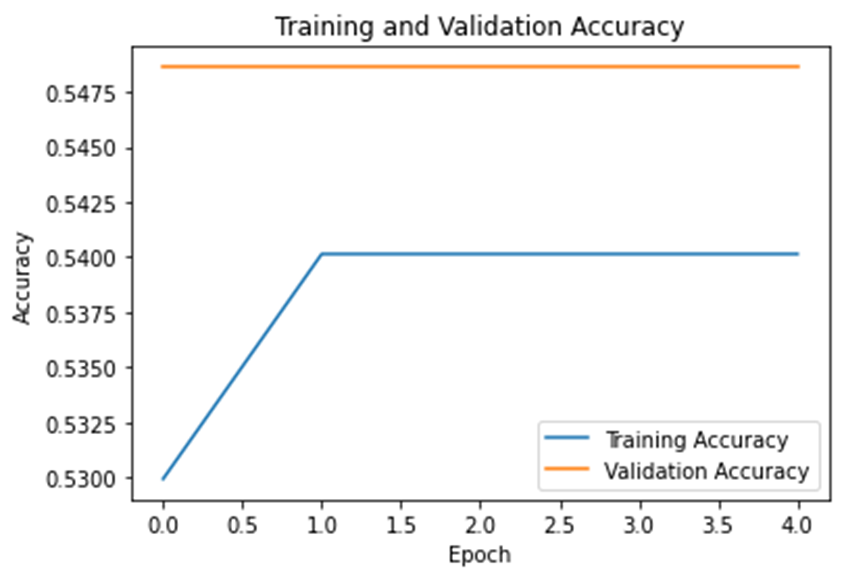

In [ ]:
vgg16()

Found 9590 images belonging to 4 classes.
Found 1686 images belonging to 4 classes.
Epoch 1/50
300/300 [==============================] - ETA: 0s - loss: 0.2838 - accuracy: 0.5264  
Epoch 1: val_accuracy improved from -inf to 0.54864, saving model to best_model_vgg16.h5
300/300 [==============================] - 67s 219ms/step - loss: 0.2838 - accuracy: 0.5264 - val_loss: 1.1772 - val_accuracy: 0.5486 - lr: 0.0010
Epoch 2/50
300/300 [==============================] - ETA: 0s - loss: 0.2505 - accuracy: 0.5401  
Epoch 2: val_accuracy did not improve from 0.54864
300/300 [==============================] - 66s 218ms/step - loss: 0.2505 - accuracy: 0.5401 - val_loss: 1.1720 - val_accuracy: 0.5486 - lr: 0.0010
Epoch 3/50
300/300 [==============================] - ETA: 0s - loss: 0.2507 - accuracy: 0.5401  
Epoch 3: val_accuracy did not improve from 0.54864
300/300 [==============================] - 66s 221ms/step - loss: 0.2507 - accuracy: 0.5401 - val_loss: 1.1688 - val_accuracy: 0.5486 - lr: 0.0010
Epoch 4/50
300/300 [==============================] - ETA: 0s - loss: 0.2509 - accuracy: 0.5401  
Epoch 4: val_accuracy did not improve from 0.54864
300/300 [==============================] - 66s 219ms/step - loss: 0.2509 - accuracy: 0.5401 - val_loss: 1.1757 - val_accuracy: 0.5486 - lr: 0.0010
Epoch 5/50
300/300 [==============================] - ETA: 0s - loss: 0.2508 - accuracy: 0.5401  
Epoch 5: val_accuracy did not improve from 0.54864
300/300 [==============================] - 66s 219ms/step - loss: 0.2508 - accuracy: 0.5401 - val_loss: 1.1730 - val_accuracy: 0.5486 - lr: 0.0010
Epoch 5: early stopping
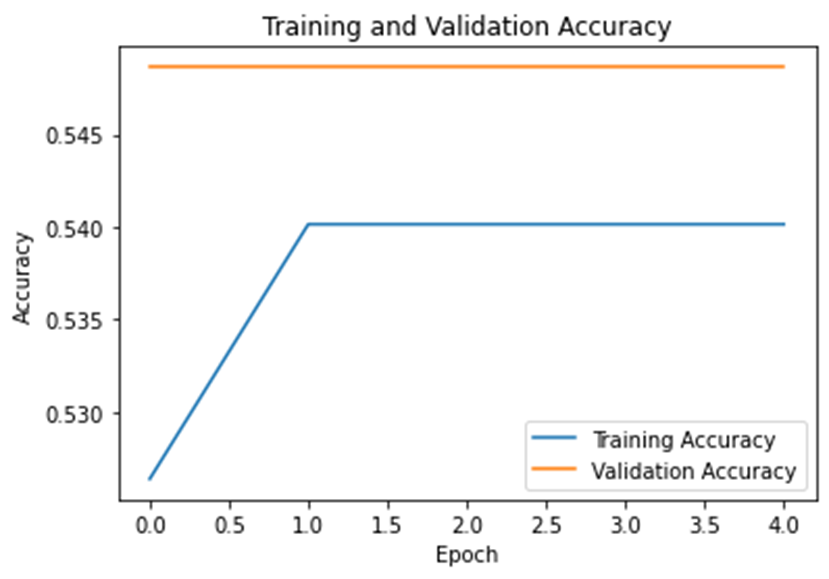

In [ ]:
densenet201()

Found 9590 images belonging to 4 classes.
Found 1686 images belonging to 4 classes.
Epoch 1/50
300/300 [==============================] - ETA: 0s - loss: 0.5319 - accuracy: 0.4757       
Epoch 1: val_accuracy improved from -inf to 0.57058, saving model to densenet201.h5
300/300 [==============================] - 103s 315ms/step - loss: 0.5319 - accuracy: 0.4757 - val_loss: 1.4380 - val_accuracy: 0.5706 - lr: 0.0010
Epoch 2/50
300/300 [==============================] - ETA: 0s - loss: 0.2629 - accuracy: 0.5242  
Epoch 2: val_accuracy did not improve from 0.57058
300/300 [==============================] - 98s 327ms/step - loss: 0.2629 - accuracy: 0.5242 - val_loss: 1.3755 - val_accuracy: 0.4294 - lr: 0.0010
Epoch 3/50
300/300 [==============================] - ETA: 0s - loss: 0.2386 - accuracy: 0.5463  
Epoch 3: val_accuracy improved from 0.57058 to 0.60202, saving model to densenet201.h5
300/300 [==============================] - 76s 252ms/step - loss: 0.2386 - accuracy: 0.5463 - val_loss: 1.1364 - val_accuracy: 0.6020 - lr: 0.0010
Epoch 4/50
300/300 [==============================] - ETA: 0s - loss: 0.2210 - accuracy: 0.5639  
Epoch 4: val_accuracy did not improve from 0.60202
300/300 [==============================] - 80s 265ms/step - loss: 0.2210 - accuracy: 0.5639 - val_loss: 1.0403 - val_accuracy: 0.5676 - lr: 0.0010
Epoch 5/50
300/300 [==============================] - ETA: 0s - loss: 0.2101 - accuracy: 0.5776  
Epoch 5: val_accuracy improved from 0.60202 to 0.60439, saving model to densenet201.h5
300/300 [==============================] - 85s 285ms/step - loss: 0.2101 - accuracy: 0.5776 - val_loss: 0.9572 - val_accuracy: 0.6044 - lr: 0.0010
Epoch 6/50
300/300 [==============================] - ETA: 0s - loss: 0.2070 - accuracy: 0.5927  
Epoch 6: val_accuracy improved from 0.60439 to 0.61151, saving model to densenet201.h5
300/300 [==============================] - 80s 266ms/step - loss: 0.2070 - accuracy: 0.5927 - val_loss: 0.9998 - val_accuracy: 0.6115 - lr: 0.0010
Epoch 7/50
300/300 [==============================] - ETA: 0s - loss: 0.2043 - accuracy: 0.5919  
Epoch 7: val_accuracy did not improve from 0.61151
300/300 [==============================] - 78s 261ms/step - loss: 0.2043 - accuracy: 0.5919 - val_loss: 0.9187 - val_accuracy: 0.6079 - lr: 0.0010
Epoch 8/50
300/300 [==============================] - ETA: 0s - loss: 0.2033 - accuracy: 0.5895  
Epoch 8: val_accuracy did not improve from 0.61151
300/300 [==============================] - 80s 265ms/step - loss: 0.2033 - accuracy: 0.5895 - val_loss: 0.9496 - val_accuracy: 0.5967 - lr: 0.0010
Epoch 9/50
300/300 [==============================] - ETA: 0s - loss: 0.2031 - accuracy: 0.5916  
Epoch 9: val_accuracy did not improve from 0.61151
300/300 [==============================] - 78s 259ms/step - loss: 0.2031 - accuracy: 0.5916 - val_loss: 0.9306 - val_accuracy: 0.6109 - lr: 0.0010
Epoch 9: early stopping
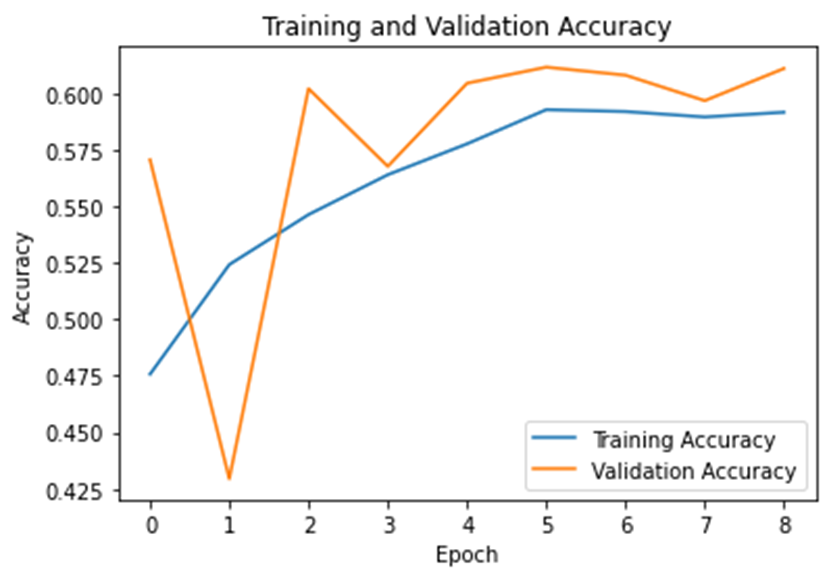

In [ ]:
densenet169()

Found 9590 images belonging to 4 classes.
Found 1686 images belonging to 4 classes.
Epoch 1/50
300/300 [==============================] - ETA: 0s - loss: 0.6489 - accuracy: 0.4847   
Epoch 1: val_accuracy improved from -inf to 0.57117, saving model to densenet169.h5
300/300 [==============================] - 85s 265ms/step - loss: 0.6489 - accuracy: 0.4847 - val_loss: 1.0711 - val_accuracy: 0.5712 - lr: 0.0010
Epoch 2/50
300/300 [==============================] - ETA: 0s - loss: 0.2432 - accuracy: 0.5504  
Epoch 2: val_accuracy did not improve from 0.57117
300/300 [==============================] - 76s 255ms/step - loss: 0.2432 - accuracy: 0.5504 - val_loss: 1.2069 - val_accuracy: 0.5297 - lr: 0.0010
Epoch 3/50
300/300 [==============================] - ETA: 0s - loss: 0.2326 - accuracy: 0.5577  
Epoch 3: val_accuracy improved from 0.57117 to 0.59905, saving model to densenet169.h5
300/300 [==============================] - 77s 255ms/step - loss: 0.2326 - accuracy: 0.5577 - val_loss: 0.9994 - val_accuracy: 0.5991 - lr: 0.0010
Epoch 4/50
300/300 [==============================] - ETA: 0s - loss: 0.2084 - accuracy: 0.5876  
Epoch 4: val_accuracy improved from 0.59905 to 0.60913, saving model to densenet169.h5
300/300 [==============================] - 98s 327ms/step - loss: 0.2084 - accuracy: 0.5876 - val_loss: 0.9190 - val_accuracy: 0.6091 - lr: 0.0010
Epoch 5/50
300/300 [==============================] - ETA: 0s - loss: 0.2015 - accuracy: 0.5955  
Epoch 5: val_accuracy improved from 0.60913 to 0.61269, saving model to densenet169.h5
300/300 [==============================] - 150s 498ms/step - loss: 0.2015 - accuracy: 0.5955 - val_loss: 0.8911 - val_accuracy: 0.6127 - lr: 0.0010
Epoch 6/50
300/300 [==============================] - ETA: 0s - loss: 0.1993 - accuracy: 0.6003  
Epoch 6: val_accuracy improved from 0.61269 to 0.61507, saving model to densenet169.h5
300/300 [==============================] - 81s 270ms/step - loss: 0.1993 - accuracy: 0.6003 - val_loss: 0.9060 - val_accuracy: 0.6151 - lr: 0.0010
Epoch 7/50
300/300 [==============================] - ETA: 0s - loss: 0.1936 - accuracy: 0.6135  
Epoch 7: val_accuracy improved from 0.61507 to 0.62633, saving model to densenet169.h5
300/300 [==============================] - 75s 249ms/step - loss: 0.1936 - accuracy: 0.6135 - val_loss: 0.8838 - val_accuracy: 0.6263 - lr: 0.0010
Epoch 8/50
300/300 [==============================] - ETA: 0s - loss: 0.1969 - accuracy: 0.6094  
Epoch 8: val_accuracy did not improve from 0.62633
300/300 [==============================] - 83s 278ms/step - loss: 0.1969 - accuracy: 0.6094 - val_loss: 0.8868 - val_accuracy: 0.6157 - lr: 0.0010
Epoch 9/50
300/300 [==============================] - ETA: 0s - loss: 0.1962 - accuracy: 0.6079  
Epoch 9: val_accuracy did not improve from 0.62633
300/300 [==============================] - 76s 254ms/step - loss: 0.1962 - accuracy: 0.6079 - val_loss: 0.9646 - val_accuracy: 0.5777 - lr: 0.0010
Epoch 10/50
300/300 [==============================] - ETA: 0s - loss: 0.1943 - accuracy: 0.6141  
Epoch 10: val_accuracy did not improve from 0.62633
300/300 [==============================] - 82s 273ms/step - loss: 0.1943 - accuracy: 0.6141 - val_loss: 0.9169 - val_accuracy: 0.6014 - lr: 0.0010
Epoch 11/50
300/300 [==============================] - ETA: 0s - loss: 0.1928 - accuracy: 0.6057  
Epoch 11: val_accuracy did not improve from 0.62633
300/300 [==============================] - 74s 246ms/step - loss: 0.1928 - accuracy: 0.6057 - val_loss: 0.9144 - val_accuracy: 0.6091 - lr: 0.0010
Epoch 12/50
300/300 [==============================] - ETA: 0s - loss: 0.1893 - accuracy: 0.6078  
Epoch 12: val_accuracy did not improve from 0.62633
300/300 [==============================] - 74s 245ms/step - loss: 0.1893 - accuracy: 0.6078 - val_loss: 0.8729 - val_accuracy: 0.6246 - lr: 0.0010
Epoch 13/50
300/300 [==============================] - ETA: 0s - loss: 0.1909 - accuracy: 0.6169  
Epoch 13: val_accuracy did not improve from 0.62633
300/300 [==============================] - 74s 246ms/step - loss: 0.1909 - accuracy: 0.6169 - val_loss: 0.8942 - val_accuracy: 0.6251 - lr: 0.0010
Epoch 14/50
300/300 [==============================] - ETA: 0s - loss: 0.1914 - accuracy: 0.6111  
Epoch 14: val_accuracy did not improve from 0.62633
300/300 [==============================] - 74s 247ms/step - loss: 0.1914 - accuracy: 0.6111 - val_loss: 0.9105 - val_accuracy: 0.6192 - lr: 0.0010
Epoch 15/50
300/300 [==============================] - ETA: 0s - loss: 0.1935 - accuracy: 0.6129  
Epoch 15: val_accuracy did not improve from 0.62633
300/300 [==============================] - 74s 247ms/step - loss: 0.1935 - accuracy: 0.6129 - val_loss: 0.8935 - val_accuracy: 0.6026 - lr: 0.0010
Epoch 16/50
300/300 [==============================] - ETA: 0s - loss: 0.1926 - accuracy: 0.6111  
Epoch 16: val_accuracy did not improve from 0.62633
300/300 [==============================] - 75s 250ms/step - loss: 0.1926 - accuracy: 0.6111 - val_loss: 0.9017 - val_accuracy: 0.6139 - lr: 0.0010
Epoch 16: early stopping
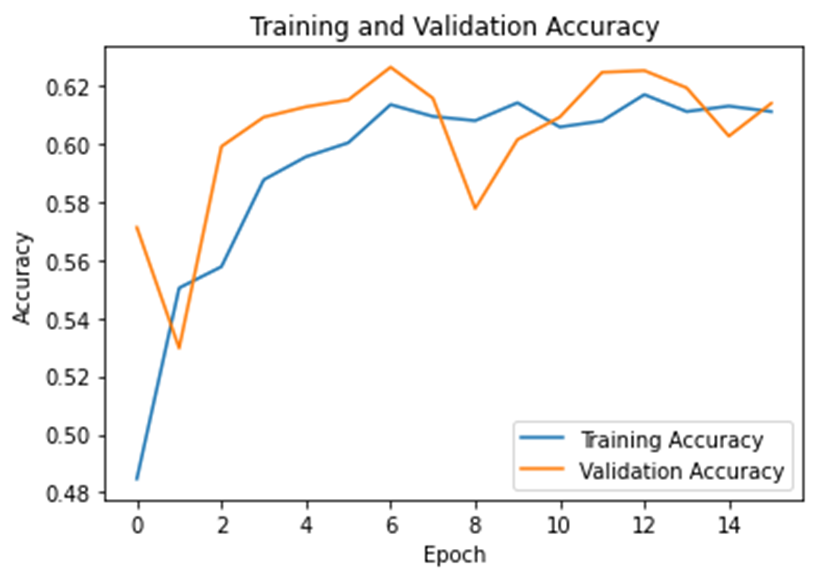

In [ ]:
densenet121()

Found 9590 images belonging to 4 classes.
Found 1686 images belonging to 4 classes.
Epoch 1/50
300/300 [==============================] - ETA: 0s - loss: 0.5549 - accuracy: 0.4788   
Epoch 1: val_accuracy improved from -inf to 0.59193, saving model to densenet121.h5
300/300 [==============================] - 93s 295ms/step - loss: 0.5549 - accuracy: 0.4788 - val_loss: 0.9804 - val_accuracy: 0.5919 - lr: 0.0010
Epoch 2/50
300/300 [==============================] - ETA: 0s - loss: 0.2557 - accuracy: 0.5370  
Epoch 2: val_accuracy did not improve from 0.59193
300/300 [==============================] - 78s 261ms/step - loss: 0.2557 - accuracy: 0.5370 - val_loss: 0.9876 - val_accuracy: 0.5830 - lr: 0.0010
Epoch 3/50
300/300 [==============================] - ETA: 0s - loss: 0.2279 - accuracy: 0.5535  
Epoch 3: val_accuracy improved from 0.59193 to 0.60558, saving model to densenet121.h5
300/300 [==============================] - 77s 255ms/step - loss: 0.2279 - accuracy: 0.5535 - val_loss: 0.8995 - val_accuracy: 0.6056 - lr: 0.0010
Epoch 4/50
300/300 [==============================] - ETA: 0s - loss: 0.2132 - accuracy: 0.5760  
Epoch 4: val_accuracy improved from 0.60558 to 0.60854, saving model to densenet121.h5
300/300 [==============================] - 75s 249ms/step - loss: 0.2132 - accuracy: 0.5760 - val_loss: 0.8952 - val_accuracy: 0.6085 - lr: 0.0010
Epoch 5/50
300/300 [==============================] - ETA: 0s - loss: 0.2045 - accuracy: 0.5907  
Epoch 5: val_accuracy improved from 0.60854 to 0.61803, saving model to densenet121.h5
300/300 [==============================] - 75s 250ms/step - loss: 0.2045 - accuracy: 0.5907 - val_loss: 0.9013 - val_accuracy: 0.6180 - lr: 0.0010
Epoch 6/50
300/300 [==============================] - ETA: 0s - loss: 0.2010 - accuracy: 0.6013  
Epoch 6: val_accuracy did not improve from 0.61803
300/300 [==============================] - 74s 247ms/step - loss: 0.2010 - accuracy: 0.6013 - val_loss: 0.9833 - val_accuracy: 0.5807 - lr: 0.0010
Epoch 7/50
300/300 [==============================] - ETA: 0s - loss: 0.1996 - accuracy: 0.6015  
Epoch 7: val_accuracy improved from 0.61803 to 0.62159, saving model to densenet121.h5
300/300 [==============================] - 75s 251ms/step - loss: 0.1996 - accuracy: 0.6015 - val_loss: 0.8782 - val_accuracy: 0.6216 - lr: 0.0010
Epoch 8/50
300/300 [==============================] - ETA: 0s - loss: 0.1961 - accuracy: 0.6103  
Epoch 8: val_accuracy improved from 0.62159 to 0.62218, saving model to densenet121.h5
300/300 [==============================] - 75s 250ms/step - loss: 0.1961 - accuracy: 0.6103 - val_loss: 0.8771 - val_accuracy: 0.6222 - lr: 0.0010
Epoch 9/50
300/300 [==============================] - ETA: 0s - loss: 0.1968 - accuracy: 0.6044  
Epoch 9: val_accuracy did not improve from 0.62218
300/300 [==============================] - 92s 308ms/step - loss: 0.1968 - accuracy: 0.6044 - val_loss: 0.9190 - val_accuracy: 0.6109 - lr: 0.0010
Epoch 10/50
300/300 [==============================] - ETA: 0s - loss: 0.1970 - accuracy: 0.6026  
Epoch 10: val_accuracy did not improve from 0.62218
300/300 [==============================] - 72s 238ms/step - loss: 0.1970 - accuracy: 0.6026 - val_loss: 0.9101 - val_accuracy: 0.5996 - lr: 0.0010
Epoch 11/50
300/300 [==============================] - ETA: 0s - loss: 0.1958 - accuracy: 0.6081  
Epoch 11: val_accuracy improved from 0.62218 to 0.62871, saving model to densenet121.h5
300/300 [==============================] - 72s 238ms/step - loss: 0.1958 - accuracy: 0.6081 - val_loss: 0.8674 - val_accuracy: 0.6287 - lr: 0.0010
Epoch 11: early stopping
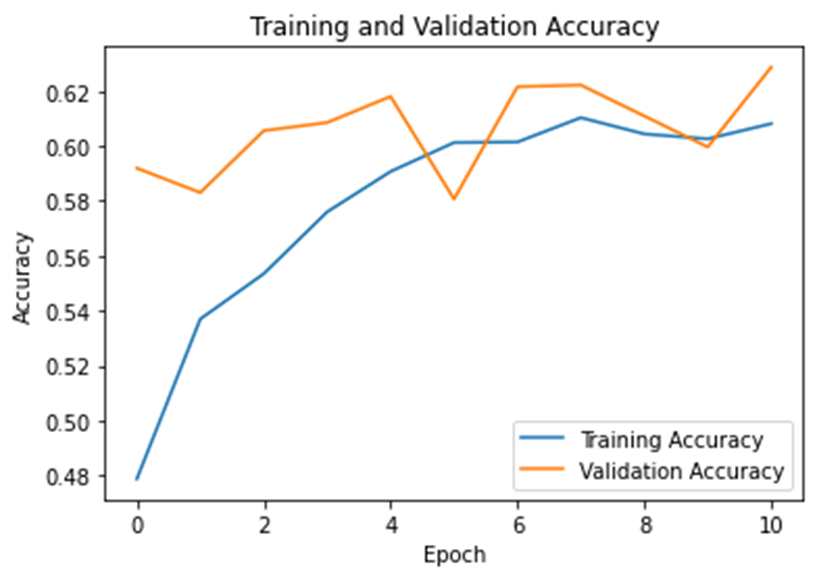

In [ ]:
mobilenet_v2()

Found 9590 images belonging to 4 classes.
Found 1686 images belonging to 4 classes.
Epoch 1/50
300/300 [==============================] - ETA: 0s - loss: 0.2462 - accuracy: 0.5098  
Epoch 1: val_accuracy improved from -inf to 0.58304, saving model to mobilenet_v2.h5
300/300 [==============================] - 70s 229ms/step - loss: 0.2462 - accuracy: 0.5098 - val_loss: 0.9901 - val_accuracy: 0.5830 - lr: 0.0010
Epoch 2/50
300/300 [==============================] - ETA: 0s - loss: 0.2193 - accuracy: 0.5455  
Epoch 2: val_accuracy did not improve from 0.58304
300/300 [==============================] - 65s 216ms/step - loss: 0.2193 - accuracy: 0.5455 - val_loss: 0.9807 - val_accuracy: 0.5706 - lr: 0.0010
Epoch 3/50
300/300 [==============================] - ETA: 0s - loss: 0.2171 - accuracy: 0.5582  
Epoch 3: val_accuracy did not improve from 0.58304
300/300 [==============================] - 63s 211ms/step - loss: 0.2171 - accuracy: 0.5582 - val_loss: 1.0201 - val_accuracy: 0.5439 - lr: 0.0010
Epoch 4/50
300/300 [==============================] - ETA: 0s - loss: 0.2119 - accuracy: 0.5638  
Epoch 4: val_accuracy did not improve from 0.58304
300/300 [==============================] - 62s 207ms/step - loss: 0.2119 - accuracy: 0.5638 - val_loss: 1.0128 - val_accuracy: 0.5368 - lr: 0.0010
Epoch 5/50
300/300 [==============================] - ETA: 0s - loss: 0.2107 - accuracy: 0.5687  
Epoch 5: val_accuracy improved from 0.58304 to 0.60083, saving model to mobilenet_v2.h5
300/300 [==============================] - 58s 195ms/step - loss: 0.2107 - accuracy: 0.5687 - val_loss: 0.9763 - val_accuracy: 0.6008 - lr: 0.0010
Epoch 6/50
300/300 [==============================] - ETA: 0s - loss: 0.2097 - accuracy: 0.5742  
Epoch 6: val_accuracy did not improve from 0.60083
300/300 [==============================] - 59s 196ms/step - loss: 0.2097 - accuracy: 0.5742 - val_loss: 0.9638 - val_accuracy: 0.5813 - lr: 0.0010
Epoch 7/50
300/300 [==============================] - ETA: 0s - loss: 0.2077 - accuracy: 0.5712  
Epoch 7: val_accuracy did not improve from 0.60083
300/300 [==============================] - 59s 198ms/step - loss: 0.2077 - accuracy: 0.5712 - val_loss: 0.9440 - val_accuracy: 0.6002 - lr: 0.0010
Epoch 8/50
300/300 [==============================] - ETA: 0s - loss: 0.2080 - accuracy: 0.5727  
Epoch 8: val_accuracy did not improve from 0.60083
300/300 [==============================] - 58s 194ms/step - loss: 0.2080 - accuracy: 0.5727 - val_loss: 0.9300 - val_accuracy: 0.6008 - lr: 0.0010
Epoch 9/50
300/300 [==============================] - ETA: 0s - loss: 0.2068 - accuracy: 0.5742  
Epoch 9: val_accuracy did not improve from 0.60083
300/300 [==============================] - 62s 206ms/step - loss: 0.2068 - accuracy: 0.5742 - val_loss: 0.9587 - val_accuracy: 0.5961 - lr: 0.0010
Epoch 9: early stopping
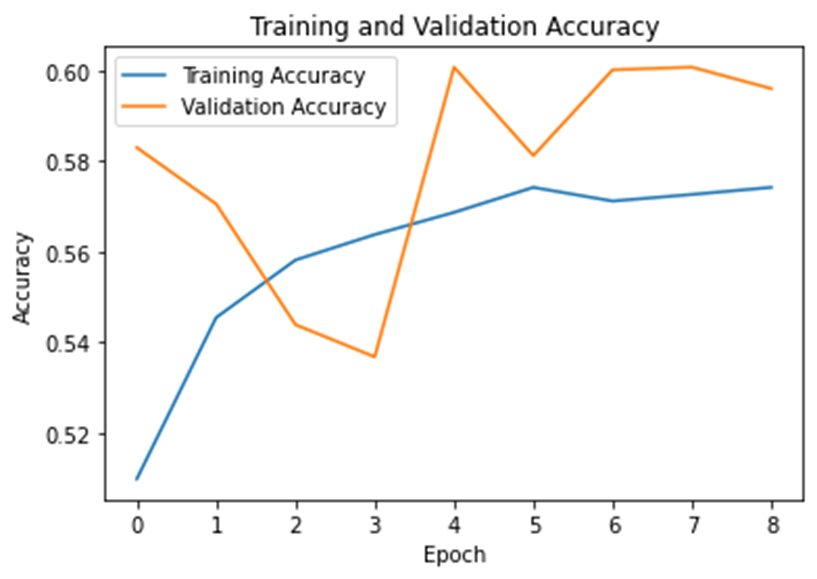

In [ ]:
mobilenet()

Found 9590 images belonging to 4 classes.
Found 1686 images belonging to 4 classes.
Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/mobilenet/mobilenet_1_0_224_tf_no_top.h5
17225924/17225924 [==============================] - 4s 0us/step
Epoch 1/50
300/300 [==============================] - ETA: 0s - loss: 0.2374 - accuracy: 0.5345  
Epoch 1: val_accuracy improved from -inf to 0.55338, saving model to mobilenet.h5
300/300 [==============================] - 64s 210ms/step - loss: 0.2374 - accuracy: 0.5345 - val_loss: 0.9929 - val_accuracy: 0.5534 - lr: 0.0010
Epoch 2/50
300/300 [==============================] - ETA: 0s - loss: 0.2076 - accuracy: 0.5787  
Epoch 2: val_accuracy improved from 0.55338 to 0.56821, saving model to mobilenet.h5
300/300 [==============================] - 61s 204ms/step - loss: 0.2076 - accuracy: 0.5787 - val_loss: 1.0086 - val_accuracy: 0.5682 - lr: 0.0010
Epoch 3/50
300/300 [==============================] - ETA: 0s - loss: 0.2038 - accuracy: 0.5847  
Epoch 3: val_accuracy improved from 0.56821 to 0.59431, saving model to mobilenet.h5
300/300 [==============================] - 60s 200ms/step - loss: 0.2038 - accuracy: 0.5847 - val_loss: 0.9190 - val_accuracy: 0.5943 - lr: 0.0010
Epoch 4/50
300/300 [==============================] - ETA: 0s - loss: 0.1981 - accuracy: 0.5922  
Epoch 4: val_accuracy improved from 0.59431 to 0.60498, saving model to mobilenet.h5
300/300 [==============================] - 66s 220ms/step - loss: 0.1981 - accuracy: 0.5922 - val_loss: 0.9097 - val_accuracy: 0.6050 - lr: 0.0010
Epoch 5/50
300/300 [==============================] - ETA: 0s - loss: 0.1977 - accuracy: 0.5935  
Epoch 5: val_accuracy did not improve from 0.60498
300/300 [==============================] - 60s 200ms/step - loss: 0.1977 - accuracy: 0.5935 - val_loss: 0.8966 - val_accuracy: 0.5985 - lr: 0.0010
Epoch 6/50
300/300 [==============================] - ETA: 0s - loss: 0.1954 - accuracy: 0.5952  
Epoch 6: val_accuracy did not improve from 0.60498
300/300 [==============================] - 60s 201ms/step - loss: 0.1954 - accuracy: 0.5952 - val_loss: 0.9200 - val_accuracy: 0.6002 - lr: 0.0010
Epoch 7/50
300/300 [==============================] - ETA: 0s - loss: 0.1938 - accuracy: 0.6039  
Epoch 7: val_accuracy did not improve from 0.60498
300/300 [==============================] - 61s 202ms/step - loss: 0.1938 - accuracy: 0.6039 - val_loss: 0.9100 - val_accuracy: 0.6044 - lr: 0.0010
Epoch 8/50
300/300 [==============================] - ETA: 0s - loss: 0.1918 - accuracy: 0.6107  
Epoch 8: val_accuracy improved from 0.60498 to 0.60676, saving model to mobilenet.h5
300/300 [==============================] - 60s 201ms/step - loss: 0.1918 - accuracy: 0.6107 - val_loss: 0.8967 - val_accuracy: 0.6068 - lr: 0.0010
Epoch 9/50
300/300 [==============================] - ETA: 0s - loss: 0.1924 - accuracy: 0.6102  
Epoch 9: val_accuracy did not improve from 0.60676
300/300 [==============================] - 61s 202ms/step - loss: 0.1924 - accuracy: 0.6102 - val_loss: 0.9035 - val_accuracy: 0.6044 - lr: 0.0010
Epoch 10/50
300/300 [==============================] - ETA: 0s - loss: 0.1903 - accuracy: 0.6114  
Epoch 10: val_accuracy did not improve from 0.60676
300/300 [==============================] - 60s 200ms/step - loss: 0.1903 - accuracy: 0.6114 - val_loss: 0.9278 - val_accuracy: 0.6068 - lr: 0.0010
Epoch 11/50
300/300 [==============================] - ETA: 0s - loss: 0.1899 - accuracy: 0.6176  
Epoch 11: val_accuracy did not improve from 0.60676
300/300 [==============================] - 60s 199ms/step - loss: 0.1899 - accuracy: 0.6176 - val_loss: 0.8950 - val_accuracy: 0.6056 - lr: 0.0010
Epoch 12/50
300/300 [==============================] - ETA: 0s - loss: 0.1887 - accuracy: 0.6160  
Epoch 12: val_accuracy did not improve from 0.60676
300/300 [==============================] - 60s 202ms/step - loss: 0.1887 - accuracy: 0.6160 - val_loss: 0.9020 - val_accuracy: 0.6044 - lr: 0.0010
Epoch 13/50
300/300 [==============================] - ETA: 0s - loss: 0.1857 - accuracy: 0.6243  
Epoch 13: val_accuracy did not improve from 0.60676
300/300 [==============================] - 63s 208ms/step - loss: 0.1857 - accuracy: 0.6243 - val_loss: 0.9032 - val_accuracy: 0.6026 - lr: 0.0010
Epoch 14/50
300/300 [==============================] - ETA: 0s - loss: 0.1867 - accuracy: 0.6162  
Epoch 14: val_accuracy did not improve from 0.60676
300/300 [==============================] - 62s 207ms/step - loss: 0.1867 - accuracy: 0.6162 - val_loss: 0.9386 - val_accuracy: 0.5967 - lr: 0.0010
Epoch 15/50
300/300 [==============================] - ETA: 0s - loss: 0.1851 - accuracy: 0.6245  
Epoch 15: val_accuracy did not improve from 0.60676
300/300 [==============================] - 63s 210ms/step - loss: 0.1851 - accuracy: 0.6245 - val_loss: 0.9058 - val_accuracy: 0.6020 - lr: 0.0010
Epoch 16/50
300/300 [==============================] - ETA: 0s - loss: 0.1829 - accuracy: 0.6262  
Epoch 16: val_accuracy improved from 0.60676 to 0.60973, saving model to mobilenet.h5
300/300 [==============================] - 73s 245ms/step - loss: 0.1829 - accuracy: 0.6262 - val_loss: 0.8937 - val_accuracy: 0.6097 - lr: 0.0010
Epoch 17/50
300/300 [==============================] - ETA: 0s - loss: 0.1825 - accuracy: 0.6260  
Epoch 17: val_accuracy did not improve from 0.60973
300/300 [==============================] - 62s 208ms/step - loss: 0.1825 - accuracy: 0.6260 - val_loss: 0.9311 - val_accuracy: 0.5902 - lr: 0.0010
Epoch 18/50
300/300 [==============================] - ETA: 0s - loss: 0.1811 - accuracy: 0.6314  
Epoch 18: val_accuracy did not improve from 0.60973
300/300 [==============================] - 63s 208ms/step - loss: 0.1811 - accuracy: 0.6314 - val_loss: 0.9052 - val_accuracy: 0.6050 - lr: 0.0010
Epoch 19/50
300/300 [==============================] - ETA: 0s - loss: 0.1813 - accuracy: 0.6306  
Epoch 19: val_accuracy improved from 0.60973 to 0.61269, saving model to mobilenet.h5
300/300 [==============================] - 63s 210ms/step - loss: 0.1813 - accuracy: 0.6306 - val_loss: 0.9129 - val_accuracy: 0.6127 - lr: 0.0010
Epoch 20/50
300/300 [==============================] - ETA: 0s - loss: 0.1818 - accuracy: 0.6294  
Epoch 20: val_accuracy did not improve from 0.61269
300/300 [==============================] - 63s 209ms/step - loss: 0.1818 - accuracy: 0.6294 - val_loss: 0.9034 - val_accuracy: 0.5973 - lr: 0.0010
Epoch 21/50
300/300 [==============================] - ETA: 0s - loss: 0.1772 - accuracy: 0.6377  
Epoch 21: val_accuracy improved from 0.61269 to 0.61684, saving model to mobilenet.h5
300/300 [==============================] - 62s 207ms/step - loss: 0.1772 - accuracy: 0.6377 - val_loss: 0.9120 - val_accuracy: 0.6168 - lr: 0.0010
Epoch 22/50
300/300 [==============================] - ETA: 0s - loss: 0.1784 - accuracy: 0.6372  
Epoch 22: val_accuracy did not improve from 0.61684
300/300 [==============================] - 62s 208ms/step - loss: 0.1784 - accuracy: 0.6372 - val_loss: 0.9120 - val_accuracy: 0.6168 - lr: 0.0010
Epoch 23/50
300/300 [==============================] - ETA: 0s - loss: 0.1783 - accuracy: 0.6371  
Epoch 23: val_accuracy did not improve from 0.61684
300/300 [==============================] - 63s 211ms/step - loss: 0.1783 - accuracy: 0.6371 - val_loss: 0.9101 - val_accuracy: 0.6109 - lr: 0.0010
Epoch 24/50
300/300 [==============================] - ETA: 0s - loss: 0.1766 - accuracy: 0.6348  
Epoch 24: val_accuracy improved from 0.61684 to 0.61862, saving model to mobilenet.h5
300/300 [==============================] - 62s 207ms/step - loss: 0.1766 - accuracy: 0.6348 - val_loss: 0.9139 - val_accuracy: 0.6186 - lr: 0.0010
Epoch 24: early stopping
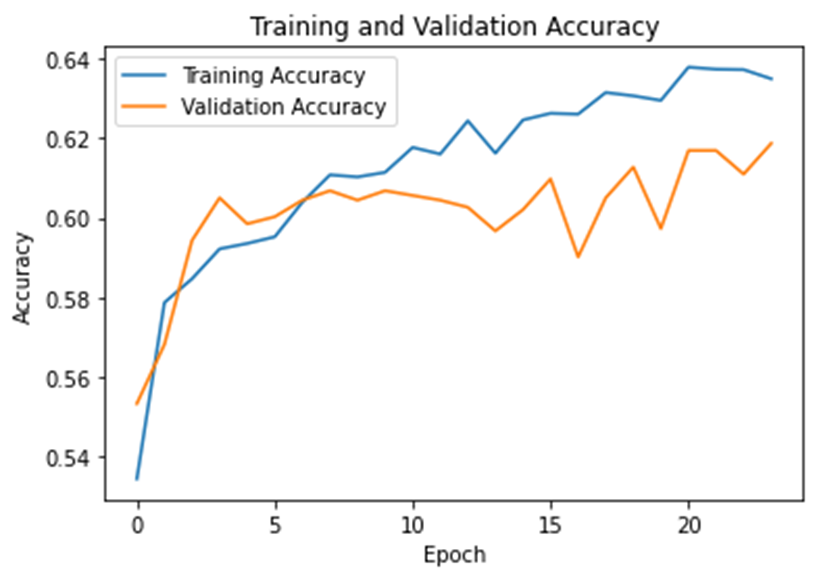

In [ ]:
xception()

Found 9590 images belonging to 4 classes.
Found 1686 images belonging to 4 classes.
Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5
83683744/83683744 [==============================] - 19s 0us/step
Epoch 1/50
300/300 [==============================] - ETA: 0s - loss: 0.3544 - accuracy: 0.4382   
Epoch 1: val_accuracy improved from -inf to 0.50652, saving model to xception.h5
300/300 [==============================] - 85s 275ms/step - loss: 0.3544 - accuracy: 0.4382 - val_loss: 1.1653 - val_accuracy: 0.5065 - lr: 0.0010
Epoch 2/50
300/300 [==============================] - ETA: 0s - loss: 0.2469 - accuracy: 0.5039  
Epoch 2: val_accuracy improved from 0.50652 to 0.55694, saving model to xception.h5
300/300 [==============================] - 92s 306ms/step - loss: 0.2469 - accuracy: 0.5039 - val_loss: 1.0781 - val_accuracy: 0.5569 - lr: 0.0010
Epoch 3/50
300/300 [==============================] - ETA: 0s - loss: 0.2398 - accuracy: 0.5154  
Epoch 3: val_accuracy did not improve from 0.55694
300/300 [==============================] - 74s 247ms/step - loss: 0.2398 - accuracy: 0.5154 - val_loss: 1.2184 - val_accuracy: 0.5445 - lr: 0.0010
Epoch 4/50
300/300 [==============================] - ETA: 0s - loss: 0.2337 - accuracy: 0.5285  
Epoch 4: val_accuracy did not improve from 0.55694
300/300 [==============================] - 72s 239ms/step - loss: 0.2337 - accuracy: 0.5285 - val_loss: 1.1661 - val_accuracy: 0.5160 - lr: 0.0010
Epoch 5/50
300/300 [==============================] - ETA: 0s - loss: 0.2334 - accuracy: 0.5261  
Epoch 5: val_accuracy improved from 0.55694 to 0.55931, saving model to xception.h5
300/300 [==============================] - 75s 251ms/step - loss: 0.2334 - accuracy: 0.5261 - val_loss: 1.0986 - val_accuracy: 0.5593 - lr: 0.0010
Epoch 6/50
300/300 [==============================] - ETA: 0s - loss: 0.2320 - accuracy: 0.5360  
Epoch 6: val_accuracy did not improve from 0.55931
300/300 [==============================] - 68s 228ms/step - loss: 0.2320 - accuracy: 0.5360 - val_loss: 1.1182 - val_accuracy: 0.5326 - lr: 0.0010
Epoch 7/50
300/300 [==============================] - ETA: 0s - loss: 0.2333 - accuracy: 0.5306  
Epoch 7: val_accuracy did not improve from 0.55931
300/300 [==============================] - 74s 245ms/step - loss: 0.2333 - accuracy: 0.5306 - val_loss: 1.0758 - val_accuracy: 0.5516 - lr: 0.0010
Epoch 8/50
300/300 [==============================] - ETA: 0s - loss: 0.2300 - accuracy: 0.5403  
Epoch 8: val_accuracy improved from 0.55931 to 0.58007, saving model to xception.h5
300/300 [==============================] - 71s 235ms/step - loss: 0.2300 - accuracy: 0.5403 - val_loss: 1.0415 - val_accuracy: 0.5801 - lr: 0.0010
Epoch 9/50
300/300 [==============================] - ETA: 0s - loss: 0.2305 - accuracy: 0.5389  
Epoch 9: val_accuracy did not improve from 0.58007
300/300 [==============================] - 69s 229ms/step - loss: 0.2305 - accuracy: 0.5389 - val_loss: 1.0321 - val_accuracy: 0.5765 - lr: 0.0010
Epoch 10/50
300/300 [==============================] - ETA: 0s - loss: 0.2302 - accuracy: 0.5409  
Epoch 10: val_accuracy did not improve from 0.58007
300/300 [==============================] - 69s 229ms/step - loss: 0.2302 - accuracy: 0.5409 - val_loss: 1.0506 - val_accuracy: 0.5581 - lr: 0.0010
Epoch 11/50
300/300 [==============================] - ETA: 0s - loss: 0.2280 - accuracy: 0.5444  
Epoch 11: val_accuracy did not improve from 0.58007
300/300 [==============================] - 69s 230ms/step - loss: 0.2280 - accuracy: 0.5444 - val_loss: 1.0245 - val_accuracy: 0.5783 - lr: 0.0010
Epoch 12/50
300/300 [==============================] - ETA: 0s - loss: 0.2273 - accuracy: 0.5382  
Epoch 12: val_accuracy did not improve from 0.58007
300/300 [==============================] - 70s 232ms/step - loss: 0.2273 - accuracy: 0.5382 - val_loss: 1.0854 - val_accuracy: 0.5326 - lr: 0.0010
Epoch 13/50
300/300 [==============================] - ETA: 0s - loss: 0.2271 - accuracy: 0.5412  
Epoch 13: val_accuracy did not improve from 0.58007
300/300 [==============================] - 93s 310ms/step - loss: 0.2271 - accuracy: 0.5412 - val_loss: 1.0861 - val_accuracy: 0.5362 - lr: 0.0010
Epoch 14/50
300/300 [==============================] - ETA: 0s - loss: 0.2268 - accuracy: 0.5441  
Epoch 14: val_accuracy did not improve from 0.58007
300/300 [==============================] - 98s 326ms/step - loss: 0.2268 - accuracy: 0.5441 - val_loss: 1.0658 - val_accuracy: 0.5486 - lr: 0.0010
Epoch 14: early stopping
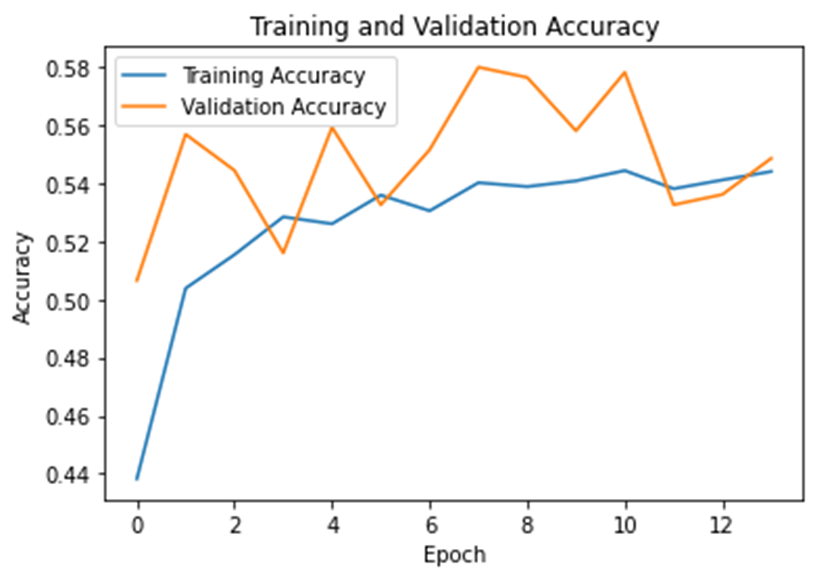

In [ ]:
inception_v3()

Found 9590 images belonging to 4 classes.
Found 1686 images belonging to 4 classes.
Epoch 1/50
300/300 [==============================] - ETA: 0s - loss: 2.0993 - accuracy: 0.3937   
Epoch 1: val_accuracy improved from -inf to 0.54864, saving model to inception_v3.h5
300/300 [==============================] - 84s 266ms/step - loss: 2.0993 - accuracy: 0.3937 - val_loss: 1.2389 - val_accuracy: 0.5486 - lr: 0.0010
Epoch 2/50
300/300 [==============================] - ETA: 0s - loss: 0.2680 - accuracy: 0.4984  
Epoch 2: val_accuracy did not improve from 0.54864
300/300 [==============================] - 68s 226ms/step - loss: 0.2680 - accuracy: 0.4984 - val_loss: 1.2442 - val_accuracy: 0.5486 - lr: 0.0010
Epoch 3/50
300/300 [==============================] - ETA: 0s - loss: 0.2612 - accuracy: 0.5219  
Epoch 3: val_accuracy did not improve from 0.54864
300/300 [==============================] - 77s 255ms/step - loss: 0.2612 - accuracy: 0.5219 - val_loss: 1.2431 - val_accuracy: 0.5486 - lr: 0.0010
Epoch 4/50
300/300 [==============================] - ETA: 0s - loss: 0.2555 - accuracy: 0.5343  
Epoch 4: val_accuracy did not improve from 0.54864
300/300 [==============================] - 90s 298ms/step - loss: 0.2555 - accuracy: 0.5343 - val_loss: 1.2108 - val_accuracy: 0.5486 - lr: 0.0010
Epoch 5/50
300/300 [==============================] - ETA: 0s - loss: 0.2541 - accuracy: 0.5340  
Epoch 5: val_accuracy did not improve from 0.54864
300/300 [==============================] - 90s 300ms/step - loss: 0.2541 - accuracy: 0.5340 - val_loss: 1.1726 - val_accuracy: 0.5486 - lr: 0.0010
Epoch 6/50
300/300 [==============================] - ETA: 0s - loss: 0.2524 - accuracy: 0.5364  
Epoch 6: val_accuracy did not improve from 0.54864
300/300 [==============================] - 88s 293ms/step - loss: 0.2524 - accuracy: 0.5364 - val_loss: 1.1812 - val_accuracy: 0.5486 - lr: 0.0010
Epoch 7/50
300/300 [==============================] - ETA: 0s - loss: 0.2523 - accuracy: 0.5371  
Epoch 7: val_accuracy did not improve from 0.54864
300/300 [==============================] - 90s 299ms/step - loss: 0.2523 - accuracy: 0.5371 - val_loss: 1.1738 - val_accuracy: 0.5486 - lr: 0.0010
Epoch 8/50
300/300 [==============================] - ETA: 0s - loss: 0.2516 - accuracy: 0.5390  
Epoch 8: val_accuracy did not improve from 0.54864
300/300 [==============================] - 90s 298ms/step - loss: 0.2516 - accuracy: 0.5390 - val_loss: 1.1695 - val_accuracy: 0.5486 - lr: 0.0010
Epoch 9/50
300/300 [==============================] - ETA: 0s - loss: 0.2518 - accuracy: 0.5382  
Epoch 9: val_accuracy did not improve from 0.54864
300/300 [==============================] - 89s 296ms/step - loss: 0.2518 - accuracy: 0.5382 - val_loss: 1.1732 - val_accuracy: 0.5486 - lr: 0.0010
Epoch 10/50
300/300 [==============================] - ETA: 0s - loss: 0.2517 - accuracy: 0.5387  
Epoch 10: val_accuracy did not improve from 0.54864
300/300 [==============================] - 100s 334ms/step - loss: 0.2517 - accuracy: 0.5387 - val_loss: 1.1724 - val_accuracy: 0.5486 - lr: 0.0010
Epoch 11/50
300/300 [==============================] - ETA: 0s - loss: 0.2510 - accuracy: 0.5387  
Epoch 11: val_accuracy did not improve from 0.54864
300/300 [==============================] - 94s 313ms/step - loss: 0.2510 - accuracy: 0.5387 - val_loss: 1.1719 - val_accuracy: 0.5486 - lr: 0.0010
Epoch 11: early stopping
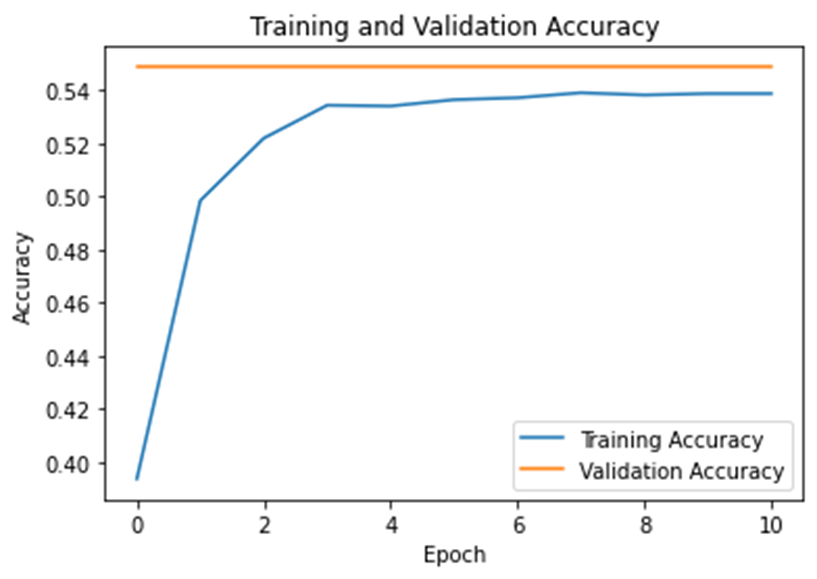

In [ ]:
lenet()

Found 9590 images belonging to 4 classes.
Found 1686 images belonging to 4 classes.
Epoch 1/50
300/300 [==============================] - ETA: 0s - loss: 0.2633 - accuracy: 0.5266  
Epoch 1: val_accuracy improved from -inf to 0.54982, saving model to best_model_lenet.keras
300/300 [==============================] - 58s 192ms/step - loss: 0.2633 - accuracy: 0.5266 - val_loss: 1.0873 - val_accuracy: 0.5498 - lr: 0.0010
Epoch 2/50
300/300 [==============================] - ETA: 0s - loss: 0.2263 - accuracy: 0.5607  
Epoch 2: val_accuracy improved from 0.54982 to 0.55219, saving model to best_model_lenet.keras
300/300 [==============================] - 57s 190ms/step - loss: 0.2263 - accuracy: 0.5607 - val_loss: 1.0754 - val_accuracy: 0.5522 - lr: 0.0010
Epoch 3/50
300/300 [==============================] - ETA: 0s - loss: 0.2208 - accuracy: 0.5589  
Epoch 3: val_accuracy improved from 0.55219 to 0.57948, saving model to best_model_lenet.keras
300/300 [==============================] - 56s 187ms/step - loss: 0.2208 - accuracy: 0.5589 - val_loss: 0.9747 - val_accuracy: 0.5795 - lr: 0.0010
Epoch 4/50
300/300 [==============================] - ETA: 0s - loss: 0.2194 - accuracy: 0.5626  
Epoch 4: val_accuracy did not improve from 0.57948
300/300 [==============================] - 57s 189ms/step - loss: 0.2194 - accuracy: 0.5626 - val_loss: 1.1660 - val_accuracy: 0.4828 - lr: 0.0010
Epoch 5/50
300/300 [==============================] - ETA: 0s - loss: 0.2165 - accuracy: 0.5677  
Epoch 5: val_accuracy did not improve from 0.57948
300/300 [==============================] - 57s 189ms/step - loss: 0.2165 - accuracy: 0.5677 - val_loss: 1.1206 - val_accuracy: 0.5113 - lr: 0.0010
Epoch 6/50
300/300 [==============================] - ETA: 0s - loss: 0.2155 - accuracy: 0.5704  
Epoch 6: val_accuracy did not improve from 0.57948
300/300 [==============================] - 56s 188ms/step - loss: 0.2155 - accuracy: 0.5704 - val_loss: 0.9943 - val_accuracy: 0.5664 - lr: 0.0010
Epoch 7/50
300/300 [==============================] - ETA: 0s - loss: 0.2154 - accuracy: 0.5663  
Epoch 7: val_accuracy improved from 0.57948 to 0.59253, saving model to best_model_lenet.keras
300/300 [==============================] - 56s 188ms/step - loss: 0.2154 - accuracy: 0.5663 - val_loss: 0.9713 - val_accuracy: 0.5925 - lr: 0.0010
Epoch 8/50
300/300 [==============================] - ETA: 0s - loss: 0.2142 - accuracy: 0.5732  
Epoch 8: val_accuracy did not improve from 0.59253
300/300 [==============================] - 56s 186ms/step - loss: 0.2142 - accuracy: 0.5732 - val_loss: 1.0363 - val_accuracy: 0.5759 - lr: 0.0010
Epoch 9/50
300/300 [==============================] - ETA: 0s - loss: 0.2081 - accuracy: 0.5851  
Epoch 9: val_accuracy did not improve from 0.59253
300/300 [==============================] - 56s 187ms/step - loss: 0.2081 - accuracy: 0.5851 - val_loss: 0.9574 - val_accuracy: 0.5854 - lr: 0.0010
Epoch 10/50
300/300 [==============================] - ETA: 0s - loss: 0.2064 - accuracy: 0.5885  
Epoch 10: val_accuracy improved from 0.59253 to 0.59846, saving model to best_model_lenet.keras
300/300 [==============================] - 56s 187ms/step - loss: 0.2064 - accuracy: 0.5885 - val_loss: 0.9001 - val_accuracy: 0.5985 - lr: 0.0010
Epoch 11/50
300/300 [==============================] - ETA: 0s - loss: 0.2063 - accuracy: 0.5923  
Epoch 11: val_accuracy did not improve from 0.59846
300/300 [==============================] - 55s 184ms/step - loss: 0.2063 - accuracy: 0.5923 - val_loss: 0.9494 - val_accuracy: 0.5937 - lr: 0.0010
Epoch 12/50
300/300 [==============================] - ETA: 0s - loss: 0.2032 - accuracy: 0.5944  
Epoch 12: val_accuracy did not improve from 0.59846
300/300 [==============================] - 56s 186ms/step - loss: 0.2032 - accuracy: 0.5944 - val_loss: 0.9361 - val_accuracy: 0.5907 - lr: 0.0010
Epoch 13/50
300/300 [==============================] - ETA: 0s - loss: 0.2007 - accuracy: 0.5983  
Epoch 13: val_accuracy improved from 0.59846 to 0.61269, saving model to best_model_lenet.keras
300/300 [==============================] - 56s 186ms/step - loss: 0.2007 - accuracy: 0.5983 - val_loss: 0.9108 - val_accuracy: 0.6127 - lr: 0.0010
Epoch 14/50
300/300 [==============================] - ETA: 0s - loss: 0.2005 - accuracy: 0.5914  
Epoch 14: val_accuracy did not improve from 0.61269
300/300 [==============================] - 55s 185ms/step - loss: 0.2005 - accuracy: 0.5914 - val_loss: 0.9159 - val_accuracy: 0.6056 - lr: 0.0010
Epoch 15/50
300/300 [==============================] - ETA: 0s - loss: 0.1979 - accuracy: 0.6028  
Epoch 15: val_accuracy did not improve from 0.61269
300/300 [==============================] - 56s 187ms/step - loss: 0.1979 - accuracy: 0.6028 - val_loss: 0.9226 - val_accuracy: 0.6062 - lr: 0.0010
Epoch 16/50
300/300 [==============================] - ETA: 0s - loss: 0.1975 - accuracy: 0.6006  
Epoch 16: val_accuracy did not improve from 0.61269
300/300 [==============================] - 56s 187ms/step - loss: 0.1975 - accuracy: 0.6006 - val_loss: 0.9466 - val_accuracy: 0.5943 - lr: 0.0010
Epoch 17/50
300/300 [==============================] - ETA: 0s - loss: 0.1963 - accuracy: 0.6059  
Epoch 17: val_accuracy improved from 0.61269 to 0.61862, saving model to best_model_lenet.keras
300/300 [==============================] - 56s 186ms/step - loss: 0.1963 - accuracy: 0.6059 - val_loss: 0.9021 - val_accuracy: 0.6186 - lr: 0.0010
Epoch 18/50
300/300 [==============================] - ETA: 0s - loss: 0.1913 - accuracy: 0.6133  
Epoch 18: val_accuracy did not improve from 0.61862
300/300 [==============================] - 56s 187ms/step - loss: 0.1913 - accuracy: 0.6133 - val_loss: 0.9227 - val_accuracy: 0.5913 - lr: 0.0010
Epoch 19/50
300/300 [==============================] - ETA: 0s - loss: 0.1931 - accuracy: 0.6126  
Epoch 19: val_accuracy improved from 0.61862 to 0.62396, saving model to best_model_lenet.keras
300/300 [==============================] - 55s 184ms/step - loss: 0.1931 - accuracy: 0.6126 - val_loss: 0.8892 - val_accuracy: 0.6240 - lr: 0.0010
Epoch 20/50
300/300 [==============================] - ETA: 0s - loss: 0.1887 - accuracy: 0.6173  
Epoch 20: val_accuracy improved from 0.62396 to 0.63227, saving model to best_model_lenet.keras
300/300 [==============================] - 58s 192ms/step - loss: 0.1887 - accuracy: 0.6173 - val_loss: 0.8797 - val_accuracy: 0.6323 - lr: 0.0010
Epoch 21/50
300/300 [==============================] - ETA: 0s - loss: 0.1905 - accuracy: 0.6119  
Epoch 21: val_accuracy did not improve from 0.63227
300/300 [==============================] - 79s 265ms/step - loss: 0.1905 - accuracy: 0.6119 - val_loss: 0.9421 - val_accuracy: 0.5985 - lr: 0.0010
Epoch 22/50
300/300 [==============================] - ETA: 0s - loss: 0.1885 - accuracy: 0.6184  
Epoch 22: val_accuracy improved from 0.63227 to 0.63701, saving model to best_model_lenet.keras
300/300 [==============================] - 63s 208ms/step - loss: 0.1885 - accuracy: 0.6184 - val_loss: 0.8814 - val_accuracy: 0.6370 - lr: 0.0010
Epoch 23/50
300/300 [==============================] - ETA: 0s - loss: 0.1853 - accuracy: 0.6262  
Epoch 23: val_accuracy did not improve from 0.63701
300/300 [==============================] - 56s 186ms/step - loss: 0.1853 - accuracy: 0.6262 - val_loss: 0.9716 - val_accuracy: 0.5421 - lr: 0.0010
Epoch 24/50
300/300 [==============================] - ETA: 0s - loss: 0.1866 - accuracy: 0.6167  
Epoch 24: val_accuracy did not improve from 0.63701
300/300 [==============================] - 63s 209ms/step - loss: 0.1866 - accuracy: 0.6167 - val_loss: 0.8993 - val_accuracy: 0.6085 - lr: 0.0010
Epoch 25/50
300/300 [==============================] - ETA: 0s - loss: 0.1826 - accuracy: 0.6252  
Epoch 25: val_accuracy did not improve from 0.63701
300/300 [==============================] - 56s 188ms/step - loss: 0.1826 - accuracy: 0.6252 - val_loss: 0.9561 - val_accuracy: 0.5830 - lr: 0.0010
Epoch 26/50
300/300 [==============================] - ETA: 0s - loss: 0.1850 - accuracy: 0.6229  
Epoch 26: val_accuracy did not improve from 0.63701
300/300 [==============================] - 56s 187ms/step - loss: 0.1850 - accuracy: 0.6229 - val_loss: 0.9706 - val_accuracy: 0.5706 - lr: 0.0010
Epoch 26: early stopping

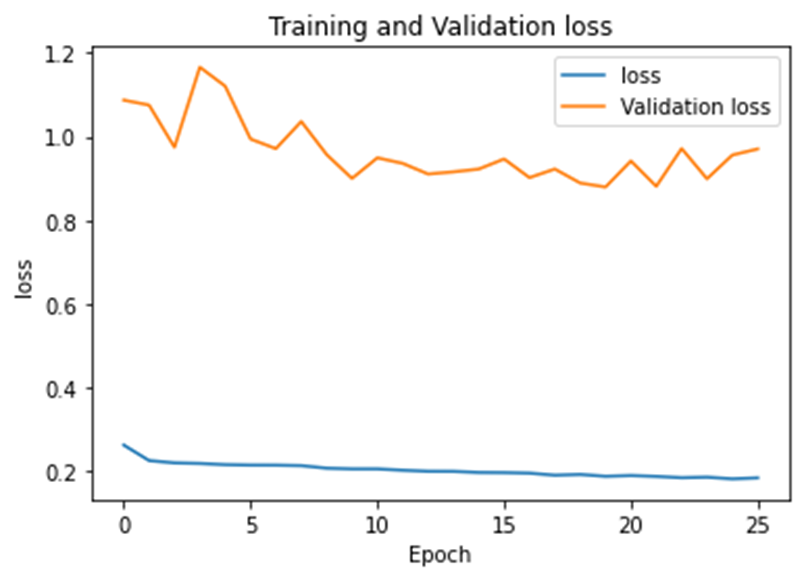

In [ ]:
alexnet()

Found 9590 images belonging to 4 classes.
Found 1686 images belonging to 4 classes.
Epoch 1/50
300/300 [==============================] - ETA: 0s - loss: 0.2575 - accuracy: 0.5311   
Epoch 1: val_accuracy improved from -inf to 0.54864, saving model to best_model_alexnet.keras
300/300 [==============================] - 58s 186ms/step - loss: 0.2575 - accuracy: 0.5311 - val_loss: 1.1416 - val_accuracy: 0.5486 - lr: 0.0010
Epoch 2/50
300/300 [==============================] - ETA: 0s - loss: 0.2515 - accuracy: 0.5400  
Epoch 2: val_accuracy did not improve from 0.54864
300/300 [==============================] - 57s 189ms/step - loss: 0.2515 - accuracy: 0.5400 - val_loss: 1.1780 - val_accuracy: 0.5486 - lr: 0.0010
Epoch 3/50
300/300 [==============================] - ETA: 0s - loss: 0.2513 - accuracy: 0.5399  
Epoch 3: val_accuracy did not improve from 0.54864
300/300 [==============================] - 57s 188ms/step - loss: 0.2513 - accuracy: 0.5399 - val_loss: 1.1892 - val_accuracy: 0.5486 - lr: 0.0010
Epoch 4/50
300/300 [==============================] - ETA: 0s - loss: 0.2512 - accuracy: 0.5401  
Epoch 4: val_accuracy did not improve from 0.54864
300/300 [==============================] - 57s 188ms/step - loss: 0.2512 - accuracy: 0.5401 - val_loss: 1.2184 - val_accuracy: 0.5486 - lr: 0.0010
Epoch 5/50
300/300 [==============================] - ETA: 0s - loss: 0.2511 - accuracy: 0.5401  
Epoch 5: val_accuracy did not improve from 0.54864
300/300 [==============================] - 56s 187ms/step - loss: 0.2511 - accuracy: 0.5401 - val_loss: 1.1894 - val_accuracy: 0.5486 - lr: 0.0010
Epoch 6/50
300/300 [==============================] - ETA: 0s - loss: 0.2511 - accuracy: 0.5401  
Epoch 6: val_accuracy did not improve from 0.54864
300/300 [==============================] - 57s 188ms/step - loss: 0.2511 - accuracy: 0.5401 - val_loss: 1.1860 - val_accuracy: 0.5486 - lr: 0.0010
Epoch 7/50
300/300 [==============================] - ETA: 0s - loss: 0.2509 - accuracy: 0.5401  
Epoch 7: val_accuracy did not improve from 0.54864
300/300 [==============================] - 56s 187ms/step - loss: 0.2509 - accuracy: 0.5401 - val_loss: 1.1774 - val_accuracy: 0.5486 - lr: 0.0010
Epoch 7: early stopping
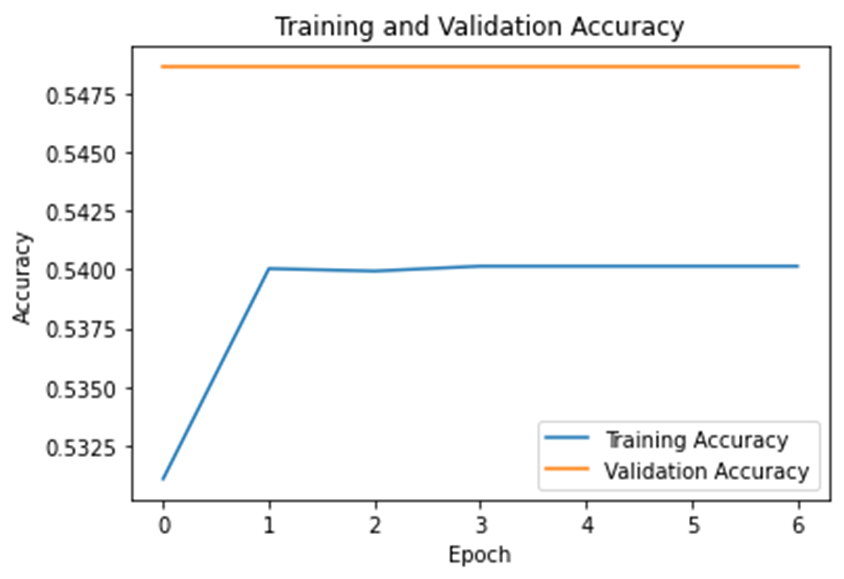

In [ ]:
resnet50()

Found 9590 images belonging to 4 classes.
Found 1686 images belonging to 4 classes.
Epoch 1/50
300/300 [==============================] - ETA: 0s - loss: 0.6626 - accuracy: 0.6594   
Epoch 1: val_accuracy improved from -inf to 0.67853, saving model to best_model_resnet.h5
300/300 [==============================] - 82s 255ms/step - loss: 0.6626 - accuracy: 0.6594 - val_loss: 1.5381 - val_accuracy: 0.6785 - lr: 0.0010
Epoch 2/50
300/300 [==============================] - ETA: 0s - loss: 0.2016 - accuracy: 0.7228  
Epoch 2: val_accuracy improved from 0.67853 to 0.71115, saving model to best_model_resnet.h5
300/300 [==============================] - 78s 260ms/step - loss: 0.2016 - accuracy: 0.7228 - val_loss: 0.6551 - val_accuracy: 0.7112 - lr: 0.0010
Epoch 3/50
300/300 [==============================] - ETA: 0s - loss: 0.1566 - accuracy: 0.7271  
Epoch 3: val_accuracy improved from 0.71115 to 0.74021, saving model to best_model_resnet.h5
300/300 [==============================] - 82s 272ms/step - loss: 0.1566 - accuracy: 0.7271 - val_loss: 0.6072 - val_accuracy: 0.7402 - lr: 0.0010
Epoch 4/50
300/300 [==============================] - ETA: 0s - loss: 0.1409 - accuracy: 0.7442  
Epoch 4: val_accuracy improved from 0.74021 to 0.74792, saving model to best_model_resnet.h5
300/300 [==============================] - 67s 223ms/step - loss: 0.1409 - accuracy: 0.7442 - val_loss: 0.5694 - val_accuracy: 0.7479 - lr: 0.0010
Epoch 5/50
300/300 [==============================] - ETA: 0s - loss: 0.1364 - accuracy: 0.7492  
Epoch 5: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 226ms/step - loss: 0.1364 - accuracy: 0.7492 - val_loss: 0.5998 - val_accuracy: 0.7420 - lr: 0.0010
Epoch 6/50
300/300 [==============================] - ETA: 0s - loss: 0.1338 - accuracy: 0.7557  
Epoch 6: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 225ms/step - loss: 0.1338 - accuracy: 0.7557 - val_loss: 0.5882 - val_accuracy: 0.7432 - lr: 0.0010
Epoch 7/50
300/300 [==============================] - ETA: 0s - loss: 0.1266 - accuracy: 0.7620  
Epoch 7: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 225ms/step - loss: 0.1266 - accuracy: 0.7620 - val_loss: 0.5993 - val_accuracy: 0.7438 - lr: 0.0010
Epoch 8/50
300/300 [==============================] - ETA: 0s - loss: 0.1253 - accuracy: 0.7653  
Epoch 8: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 227ms/step - loss: 0.1253 - accuracy: 0.7653 - val_loss: 0.5995 - val_accuracy: 0.7450 - lr: 0.0010
Epoch 9/50
300/300 [==============================] - ETA: 0s - loss: 0.1245 - accuracy: 0.7641  
Epoch 9: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 226ms/step - loss: 0.1245 - accuracy: 0.7641 - val_loss: 0.6490 - val_accuracy: 0.7147 - lr: 0.0010
Epoch 10/50
300/300 [==============================] - ETA: 0s - loss: 0.1208 - accuracy: 0.7692  
Epoch 10: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 225ms/step - loss: 0.1208 - accuracy: 0.7692 - val_loss: 0.6015 - val_accuracy: 0.7378 - lr: 0.0010
Epoch 11/50
300/300 [==============================] - ETA: 0s - loss: 0.1189 - accuracy: 0.7821  
Epoch 11: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 227ms/step - loss: 0.1189 - accuracy: 0.7821 - val_loss: 0.6719 - val_accuracy: 0.7272 - lr: 0.0010
Epoch 12/50
300/300 [==============================] - ETA: 0s - loss: 0.1169 - accuracy: 0.7808  
Epoch 12: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 227ms/step - loss: 0.1169 - accuracy: 0.7808 - val_loss: 0.5969 - val_accuracy: 0.7349 - lr: 0.0010
Epoch 13/50
300/300 [==============================] - ETA: 0s - loss: 0.1145 - accuracy: 0.7888  
Epoch 13: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 226ms/step - loss: 0.1145 - accuracy: 0.7888 - val_loss: 0.6439 - val_accuracy: 0.7289 - lr: 0.0010
Epoch 14/50
300/300 [==============================] - ETA: 0s - loss: 0.1110 - accuracy: 0.7960  
Epoch 14: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 226ms/step - loss: 0.1110 - accuracy: 0.7960 - val_loss: 0.6487 - val_accuracy: 0.7378 - lr: 0.0010
Epoch 15/50
300/300 [==============================] - ETA: 0s - loss: 0.1069 - accuracy: 0.8014  
Epoch 15: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 227ms/step - loss: 0.1069 - accuracy: 0.8014 - val_loss: 0.7194 - val_accuracy: 0.7177 - lr: 0.0010
Epoch 16/50
300/300 [==============================] - ETA: 0s - loss: 0.1040 - accuracy: 0.8121  
Epoch 16: val_accuracy did not improve from 0.74792
300/300 [==============================] - 69s 229ms/step - loss: 0.1040 - accuracy: 0.8121 - val_loss: 0.7036 - val_accuracy: 0.7289 - lr: 0.0010
Epoch 17/50
300/300 [==============================] - ETA: 0s - loss: 0.1034 - accuracy: 0.8098  
Epoch 17: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 227ms/step - loss: 0.1034 - accuracy: 0.8098 - val_loss: 0.6395 - val_accuracy: 0.7408 - lr: 0.0010
Epoch 18/50
300/300 [==============================] - ETA: 0s - loss: 0.0983 - accuracy: 0.8224  
Epoch 18: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 226ms/step - loss: 0.0983 - accuracy: 0.8224 - val_loss: 0.7212 - val_accuracy: 0.7295 - lr: 0.0010
Epoch 19/50
300/300 [==============================] - ETA: 0s - loss: 0.0951 - accuracy: 0.8314  
Epoch 19: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 227ms/step - loss: 0.0951 - accuracy: 0.8314 - val_loss: 0.7136 - val_accuracy: 0.7319 - lr: 0.0010
Epoch 20/50
300/300 [==============================] - ETA: 0s - loss: 0.0947 - accuracy: 0.8268  
Epoch 20: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 226ms/step - loss: 0.0947 - accuracy: 0.8268 - val_loss: 0.6872 - val_accuracy: 0.7248 - lr: 0.0010
Epoch 21/50
300/300 [==============================] - ETA: 0s - loss: 0.0894 - accuracy: 0.8421  
Epoch 21: val_accuracy did not improve from 0.74792
300/300 [==============================] - 69s 228ms/step - loss: 0.0894 - accuracy: 0.8421 - val_loss: 0.7174 - val_accuracy: 0.7349 - lr: 0.0010
Epoch 22/50
300/300 [==============================] - ETA: 0s - loss: 0.0880 - accuracy: 0.8468  
Epoch 22: val_accuracy did not improve from 0.74792
300/300 [==============================] - 70s 231ms/step - loss: 0.0880 - accuracy: 0.8468 - val_loss: 0.7186 - val_accuracy: 0.7212 - lr: 0.0010
Epoch 23/50
300/300 [==============================] - ETA: 0s - loss: 0.0871 - accuracy: 0.8454  
Epoch 23: val_accuracy did not improve from 0.74792
300/300 [==============================] - 69s 231ms/step - loss: 0.0871 - accuracy: 0.8454 - val_loss: 0.7976 - val_accuracy: 0.7212 - lr: 0.0010
Epoch 24/50
300/300 [==============================] - ETA: 0s - loss: 0.0808 - accuracy: 0.8540  
Epoch 24: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 227ms/step - loss: 0.0808 - accuracy: 0.8540 - val_loss: 0.8428 - val_accuracy: 0.7046 - lr: 0.0010
Epoch 25/50
300/300 [==============================] - ETA: 0s - loss: 0.0868 - accuracy: 0.8592  
Epoch 25: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 226ms/step - loss: 0.0868 - accuracy: 0.8592 - val_loss: 0.8066 - val_accuracy: 0.7301 - lr: 0.0010
Epoch 26/50
300/300 [==============================] - ETA: 0s - loss: 0.0806 - accuracy: 0.8634  
Epoch 26: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 225ms/step - loss: 0.0806 - accuracy: 0.8634 - val_loss: 0.8437 - val_accuracy: 0.7112 - lr: 0.0010
Epoch 27/50
300/300 [==============================] - ETA: 0s - loss: 0.0725 - accuracy: 0.8785  
Epoch 27: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 226ms/step - loss: 0.0725 - accuracy: 0.8785 - val_loss: 0.8006 - val_accuracy: 0.7040 - lr: 0.0010
Epoch 28/50
300/300 [==============================] - ETA: 0s - loss: 0.0713 - accuracy: 0.8797  
Epoch 28: val_accuracy did not improve from 0.74792
300/300 [==============================] - 67s 224ms/step - loss: 0.0713 - accuracy: 0.8797 - val_loss: 0.7715 - val_accuracy: 0.7260 - lr: 0.0010
Epoch 29/50
300/300 [==============================] - ETA: 0s - loss: 0.0727 - accuracy: 0.8798  
Epoch 29: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 226ms/step - loss: 0.0727 - accuracy: 0.8798 - val_loss: 0.8949 - val_accuracy: 0.7248 - lr: 0.0010
Epoch 30/50
300/300 [==============================] - ETA: 0s - loss: 0.0658 - accuracy: 0.8886  
Epoch 30: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 226ms/step - loss: 0.0658 - accuracy: 0.8886 - val_loss: 0.8950 - val_accuracy: 0.7159 - lr: 0.0010
Epoch 31/50
300/300 [==============================] - ETA: 0s - loss: 0.0654 - accuracy: 0.8905  
Epoch 31: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 225ms/step - loss: 0.0654 - accuracy: 0.8905 - val_loss: 0.8863 - val_accuracy: 0.7236 - lr: 0.0010
Epoch 32/50
300/300 [==============================] - ETA: 0s - loss: 0.0613 - accuracy: 0.8979  
Epoch 32: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 227ms/step - loss: 0.0613 - accuracy: 0.8979 - val_loss: 0.8754 - val_accuracy: 0.7295 - lr: 0.0010
Epoch 33/50
300/300 [==============================] - ETA: 0s - loss: 0.0633 - accuracy: 0.8976  
Epoch 33: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 225ms/step - loss: 0.0633 - accuracy: 0.8976 - val_loss: 0.8817 - val_accuracy: 0.7195 - lr: 0.0010
Epoch 34/50
300/300 [==============================] - ETA: 0s - loss: 0.0578 - accuracy: 0.9066  
Epoch 34: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 228ms/step - loss: 0.0578 - accuracy: 0.9066 - val_loss: 0.9411 - val_accuracy: 0.7117 - lr: 0.0010
Epoch 35/50
300/300 [==============================] - ETA: 0s - loss: 0.0555 - accuracy: 0.9149  
Epoch 35: val_accuracy did not improve from 0.74792
300/300 [==============================] - 69s 228ms/step - loss: 0.0555 - accuracy: 0.9149 - val_loss: 0.9840 - val_accuracy: 0.7200 - lr: 0.0010
Epoch 36/50
300/300 [==============================] - ETA: 0s - loss: 0.0555 - accuracy: 0.9113  
Epoch 36: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 227ms/step - loss: 0.0555 - accuracy: 0.9113 - val_loss: 1.0691 - val_accuracy: 0.7028 - lr: 0.0010
Epoch 37/50
300/300 [==============================] - ETA: 0s - loss: 0.0549 - accuracy: 0.9149  
Epoch 37: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 227ms/step - loss: 0.0549 - accuracy: 0.9149 - val_loss: 1.0770 - val_accuracy: 0.7064 - lr: 0.0010
Epoch 38/50
300/300 [==============================] - ETA: 0s - loss: 0.0541 - accuracy: 0.9196  
Epoch 38: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 227ms/step - loss: 0.0541 - accuracy: 0.9196 - val_loss: 0.9460 - val_accuracy: 0.7094 - lr: 0.0010
Epoch 39/50
300/300 [==============================] - ETA: 0s - loss: 0.0520 - accuracy: 0.9192  
Epoch 39: val_accuracy did not improve from 0.74792
300/300 [==============================] - 67s 224ms/step - loss: 0.0520 - accuracy: 0.9192 - val_loss: 1.0364 - val_accuracy: 0.7171 - lr: 0.0010
Epoch 40/50
300/300 [==============================] - ETA: 0s - loss: 0.0502 - accuracy: 0.9244  
Epoch 40: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 227ms/step - loss: 0.0502 - accuracy: 0.9244 - val_loss: 1.0434 - val_accuracy: 0.7135 - lr: 0.0010
Epoch 41/50
300/300 [==============================] - ETA: 0s - loss: 0.0507 - accuracy: 0.9317  
Epoch 41: val_accuracy did not improve from 0.74792
300/300 [==============================] - 70s 231ms/step - loss: 0.0507 - accuracy: 0.9317 - val_loss: 0.9093 - val_accuracy: 0.7195 - lr: 0.0010
Epoch 42/50
300/300 [==============================] - ETA: 0s - loss: 0.0472 - accuracy: 0.9343  
Epoch 42: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 225ms/step - loss: 0.0472 - accuracy: 0.9343 - val_loss: 1.0782 - val_accuracy: 0.7052 - lr: 0.0010
Epoch 43/50
300/300 [==============================] - ETA: 0s - loss: 0.0445 - accuracy: 0.9346  
Epoch 43: val_accuracy did not improve from 0.74792
300/300 [==============================] - 69s 228ms/step - loss: 0.0445 - accuracy: 0.9346 - val_loss: 1.0188 - val_accuracy: 0.7230 - lr: 0.0010
Epoch 44/50
300/300 [==============================] - ETA: 0s - loss: 0.0421 - accuracy: 0.9384  
Epoch 44: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 225ms/step - loss: 0.0421 - accuracy: 0.9384 - val_loss: 1.1722 - val_accuracy: 0.6839 - lr: 0.0010
Epoch 45/50
300/300 [==============================] - ETA: 0s - loss: 0.0514 - accuracy: 0.9337  
Epoch 45: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 226ms/step - loss: 0.0514 - accuracy: 0.9337 - val_loss: 1.0188 - val_accuracy: 0.7189 - lr: 0.0010
Epoch 46/50
300/300 [==============================] - ETA: 0s - loss: 0.0439 - accuracy: 0.9418  
Epoch 46: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 226ms/step - loss: 0.0439 - accuracy: 0.9418 - val_loss: 1.0596 - val_accuracy: 0.7260 - lr: 0.0010
Epoch 47/50
300/300 [==============================] - ETA: 0s - loss: 0.0430 - accuracy: 0.9398  
Epoch 47: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 226ms/step - loss: 0.0430 - accuracy: 0.9398 - val_loss: 0.9749 - val_accuracy: 0.7183 - lr: 0.0010
Epoch 48/50
300/300 [==============================] - ETA: 0s - loss: 0.0388 - accuracy: 0.9447  
Epoch 48: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 226ms/step - loss: 0.0388 - accuracy: 0.9447 - val_loss: 1.1421 - val_accuracy: 0.7236 - lr: 0.0010
Epoch 49/50
300/300 [==============================] - ETA: 0s - loss: 0.0391 - accuracy: 0.9449  
Epoch 49: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 226ms/step - loss: 0.0391 - accuracy: 0.9449 - val_loss: 1.2081 - val_accuracy: 0.7094 - lr: 0.0010
Epoch 50/50
300/300 [==============================] - ETA: 0s - loss: 0.0371 - accuracy: 0.9486  
Epoch 50: val_accuracy did not improve from 0.74792
300/300 [==============================] - 68s 225ms/step - loss: 0.0371 - accuracy: 0.9486 - val_loss: 1.2601 - val_accuracy: 0.7011 - lr: 0.0010
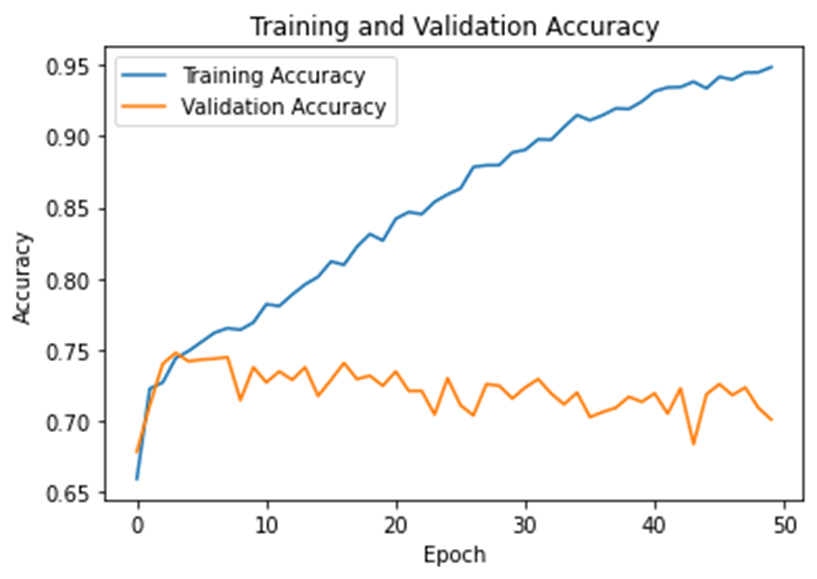

In [ ]:
trained_model = tf.keras.models.load_model('/content/drive/MyDrive/Ulcerative Colitis/best_model_alexnet.keras')
trained_model.save('/content/drive/MyDrive/Ulcerative Colitis/best_model_alexnet.h5')

In [ ]:
trained_model = tf.keras.models.load_model('/content/drive/MyDrive/Ulcerative Colitis/best_model_lenet.keras')
trained_model.save('/content/drive/MyDrive/Ulcerative Colitis/best_model_lenet.h5')

In [ ]:
trained_model = tf.keras.models.load_model('/content/drive/MyDrive/Ulcerative Colitis/best_model_resnet.keras')
trained_model.save('/content/drive/MyDrive/Ulcerative Colitis/best_model_resnet.h5')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf

image_height, image_width = 224, 224
num_classes = 4  # Make sure this matches the actual number of classes
batch_size = 32
epochs = 10
train_data_dir = '/content/drive/MyDrive/Ulcerative Colitis/train_and_validation_sets/train_and_validation_sets'
val_data_dir = '/content/drive/MyDrive/Ulcerative Colitis/test_set/test_set'

# Data generators for training and validation
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Training data generator
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(image_height, image_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

# Validation data generator
val_generator = val_datagen.flow_from_directory(val_data_dir,
                                                target_size=(image_height, image_width),
                                                batch_size=batch_size,
                                                class_mode='categorical')

# Load the trained models
trained_model1 = tf.keras.models.load_model('/content/drive/MyDrive/Ulcerative Colitis/best_model_resnet.h5')
trained_model2 = tf.keras.models.load_model('/content/drive/MyDrive/Ulcerative Colitis/best_model_alexnet.h5')
trained_model3 = tf.keras.models.load_model('/content/drive/MyDrive/Ulcerative Colitis/best_model_lenet.h5')

# Evaluate the models on the validation data
val_loss1, val_accuracy1 = trained_model1.evaluate(val_generator)
print(f'ResNet: Validation Loss: {val_loss1:.4f}, Validation Accuracy: {val_accuracy1:.4f}')

val_loss2, val_accuracy2 = trained_model2.evaluate(val_generator)
print(f'AlexNet: Validation Loss: {val_loss2:.4f}, Validation Accuracy: {val_accuracy2:.4f}')

val_loss3, val_accuracy3 = trained_model3.evaluate(val_generator)
print(f'LeNet: Validation Loss: {val_loss3:.4f}, Validation Accuracy: {val_accuracy3:.4f}')


Found 4170 images belonging to 4 classes.
Found 864 images belonging to 4 classes.
27/27 [==============================] - 558s 21s/step - loss: 0.9891 - accuracy: 0.7072
ResNet: Validation Loss: 0.9891, Validation Accuracy: 0.7072
27/27 [==============================] - 22s 796ms/step - loss: 57.8681 - accuracy: 0.1215
AlexNet: Validation Loss: 57.8681, Validation Accuracy: 0.1215
27/27 [==============================] - 15s 548ms/step - loss: 129.3588 - accuracy: 0.1215
LeNet: Validation Loss: 129.3588, Validation Accuracy: 0.1215


1/1 [==============================] - 1s 1s/step


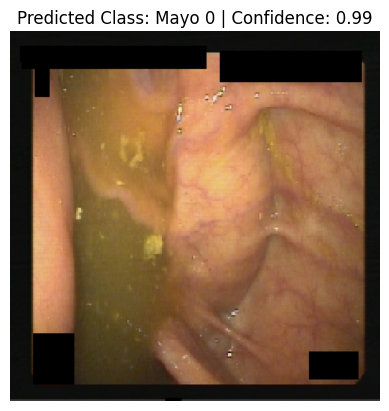

In [ ]:
image_path = '/content/drive/MyDrive/Ulcerative Colitis/patient_based_classified_images/patient_based_classified_images/2/Mayo 0/UC_patient_2_10.bmp'

# Preprocess the input image
img = image.load_img(image_path, target_size=(image_height, image_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make prediction
prediction = trained_model.predict(img_array)

# Interpret the prediction results
class_names = train_generator.class_indices
predicted_class_index = np.argmax(prediction)
for class_name, index in class_names.items():
    if index == predicted_class_index:
        predicted_class = class_name
        break

# Get the confidence score
confidence_score = prediction[0][predicted_class_index]

# Show the image with predicted class and confidence score
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted Class: {predicted_class} | Confidence: {confidence_score:.2f}')
plt.show()